<ipython-input-1-c08c4abd3d75>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['BODY_TYPE'] = clean_data['MODEL'].map(df2.set_index('MODEL')['BODY_TYPE'])


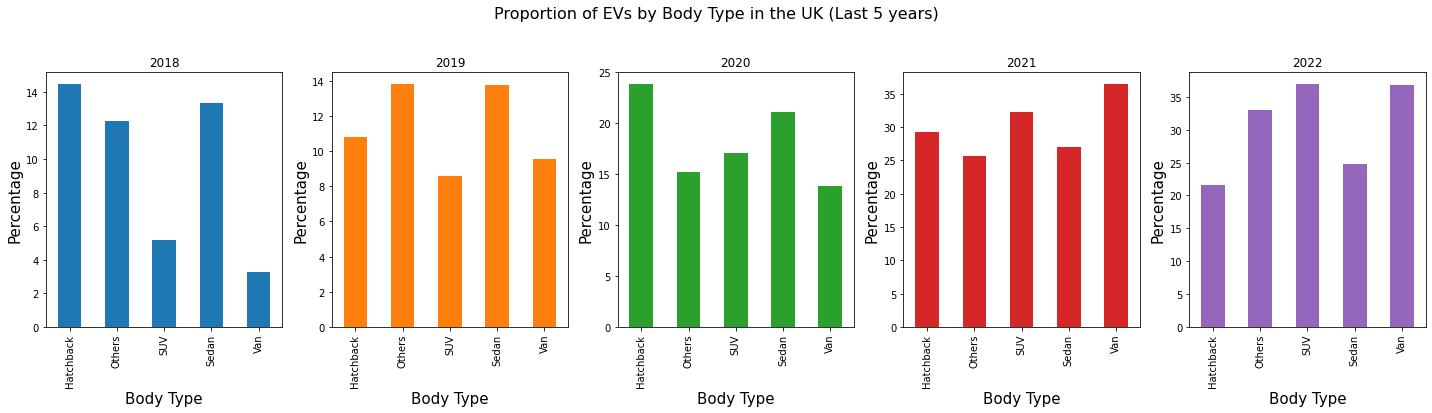

In [1]:
######### 5_2 Proportion of EVs by Body Type in the UK (Last 5 years) #########

import pandas as pd
import matplotlib.pyplot as plt

# Replace 'url_to_your_csv_file' with the raw GitHub URL of your CSV file
csv_url = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/5_2/VEH0171b_GenModels.csv?token=GHSAT0AAAAAACFKR6AC4RUJZBGKWN24SZI4ZGI5VAQ'

# Read the CSV file into a DataFrame, skipping the first 4 rows
df = pd.read_csv(csv_url, skiprows=4)

# Save the first four columns in a separate DataFrame with the renamed names
first_four_columns = df.iloc[:, :6].rename(columns={df.columns[2]: 'BODY TYPE', df.columns[3]: 'MAKE', df.columns[4]: 'MODEL', df.columns[5]: 'FUEL'})

# Drop the first two columns from the original DataFrame
df.drop(df.columns[:4], axis=1, inplace=True)

# Create a new DataFrame to store the sums
sum_df = pd.DataFrame(index=df.index)

# Iterate through columns and group by left 4 characters of the header
for col in df.columns:
    header_prefix = col[:4]
    if header_prefix not in sum_df.columns:
        selected_columns = df.loc[:, df.columns.str[:4] == header_prefix]
        sum_df[header_prefix] = pd.to_numeric(selected_columns.stack(), errors='coerce').groupby(level=0).sum()

# Print the first few rows of the new DataFrame with sums and the first four columns unchanged
result_df = pd.concat([first_four_columns, sum_df], axis=1)
new_df = result_df.drop(result_df.columns[[0, 1,6, 7]], axis=1)

# Calculate the sum of numbers from the 5th column till the last column and add a new "TOTAL" column
new_df['TOTAL'] = new_df[new_df.columns[2:]].sum(axis=1)

# Filter out rows where 'MODEL' column contains the string "MISSING"
clean_data = new_df[~new_df['MODEL'].str.contains("MISSING")]
# print(clean_data)
##################################################################
# Manually replace the EV battery capacity data file path

csv_url2 = r'https://raw.githubusercontent.com/varunraaju/Battery_Cycle_Plots/main/5_2/EV_CAPACITY.csv?token=GHSAT0AAAAAACFKR6AD2I46ULBQVV7OGEQKZGI5VPA'
df2 = pd.read_csv(csv_url2)

###################################################################
######### Plot Code ###########
# merging both the data frames
df2.columns = df2.columns.str.upper()

clean_data['BODY_TYPE'] = clean_data['MODEL'].map(df2.set_index('MODEL')['BODY_TYPE'])
clean_data = clean_data.dropna(subset=['BODY_TYPE'])
# Drop rows with NaN values in the 'BODY_TYPE' column


# List of body types to categorize
main_body_types = ['Sedan', 'SUV', 'Hatchback', 'Van']

# Categorize 'BODY TYPE' column as Sedan, SUV, Hatchback, Van, and "Others"
clean_data['BODY_TYPE_CATEGORIZED'] = clean_data['BODY_TYPE'].where(clean_data['BODY_TYPE'].isin(main_body_types), 'Others')
# List of columns from 2016 to 2022
year_columns = ['2018', '2019', '2020', '2021', '2022']

# Group by 'BODY_TYPE' and sum the columns from 2016 to 2022
grouped_data = clean_data.groupby('BODY_TYPE_CATEGORIZED')[year_columns].sum().reset_index()

# print(grouped_data.head(20))

df=grouped_data
numeric_cols = [ '2018', '2019', '2020', '2021', '2022']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)

# Set the 'BODY_TYPE_CATEGORIZED' column as the index for easy plotting
df.set_index('BODY_TYPE_CATEGORIZED', inplace=True)

# Calculate the total for each year
df['Total'] = df.sum(axis=1)

# Calculate the percentage composition for each body type in each year
for year in df.columns:
    df[year] = (df[year] / df['Total']) * 100

# Drop the 'Total' column as it is not required for plotting
df.drop(columns=['Total'], inplace=True)

# Plot the individual bar plots for each year together in a single plot
fig, axes = plt.subplots(nrows=1, ncols=len(df.columns), figsize=(20, 6))

for i, year in enumerate(df.columns):
    df[year].plot(kind='bar', ax=axes[i], color='C{}'.format(i), legend=False)
    axes[i].set_title(year)
    axes[i].set_xlabel('Body Type',fontsize=15)
    axes[i].set_ylabel('Percentage',fontsize=15)

plt.suptitle('Proportion of EVs by Body Type in the UK (Last 5 years)',fontsize = 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()